## EKSPERYMENT 1
### Komputer.

Część 1: Przygotowanie danych i trenowanie klasyfikatorów

Część 2: Dane, metoda

Część 3: Badanie jakości w strumieniu o zmiennej strudności

## Część 1: Trenowanie

In [1]:
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(5531)

# Prepare trainig data
train_data = torchvision.datasets.MNIST('./files/', 
                                  train=False, #Tak.
                                  download=True)

train_X = (torch.tensor(train_data.data)/255).to(torch.float)
train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1], train_X.shape[2])
train_y = train_data.targets

dataset = TensorDataset(torch.Tensor(train_X),torch.Tensor(train_y))
dataloader = DataLoader(dataset, batch_size=64)

print(train_X.shape)
print(train_y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


/var/folders/md/9788g9qs5h77d4hrzh39xpkc0000gn/T/ipykernel_2958/2281852813.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_X = (torch.tensor(train_data.data)/255).to(torch.float)


In [2]:
from architectures import *

# Initialize and train classifiers
max_training_epochs = 250
training_support_level = 0.95

clfs = [
    CNN(architecure=CNN1_5_Network()),
    CNN(architecure=CNN1_10_Network()),
    CNN(architecure=CNN2_10_15_Network()),
    CNN(architecure=CNN1_20_Network()),
    CNN(architecure=CNN2_25_40_Network()),  
]

loss_fn = torch.nn.CrossEntropyLoss()

for clf_id, clf in enumerate(clfs):
    optimizer = torch.optim.SGD(clf.parameters(), lr=1e-2)

    for e in range(max_training_epochs):
        if e==0:
            clf.custom_train(dataloader, loss_fn, optimizer)
        else:

            proba = nn.Softmax(dim=1)( clf(train_X))
            max_proba = torch.max(proba, dim=1)[0] 
            mean_proba = torch.mean(max_proba).detach().numpy() # średnie wsparcie decyzyjne

            if mean_proba>training_support_level:
                print(clf_id, e, mean_proba)
                break
            
            clf.custom_train(dataloader, loss_fn, optimizer)
        
        if e%50==1:
            print(clf_id, e, mean_proba)
            

0 1 0.40806052
0 51 0.9354808
0 72 0.9502322
1 1 0.5474046
1 51 0.9404277
1 63 0.95050555
2 1 0.13053115
2 22 0.9500297
3 1 0.6263041
3 50 0.9502016
4 1 0.3133268
4 19 0.95116943


In [3]:
import numpy as np

def get_th(chunk_size):
    max_probas=[]
    for c in clfs:
        proba = nn.Softmax(dim=1)(c(train_X))
        max_proba = torch.max(proba, dim=1)[0]
        max_probas.append(max_proba.detach().numpy())
        
    mp = np.array(max_probas).flatten()
    aa = int(len(mp)/chunk_size)
    mp = mp[:aa*chunk_size]
    mp = mp.reshape(aa,chunk_size)
    mp = np.mean(mp, axis=1)

    n_bins=7
    bin_size = int(len(mp)/n_bins)

    th = []
    argsort_mp = np.argsort(mp)

    for b in range(n_bins-1):
        th.append(mp[argsort_mp[b*bin_size]])

    # th.append(1)
    th.reverse()
    # th.pop()
    th[0]=1.
    return th
    

In [4]:
print(get_th(50))
print(get_th(150))
print(get_th(350))
print(get_th(500))

[1.0, 0.952485, 0.94385666, 0.93445253, 0.92263573, 0.8628153]
[1.0, 0.95158255, 0.93982553, 0.9344765, 0.92807126, 0.9017509]
[1.0, 0.9508648, 0.9414787, 0.93591136, 0.93067324, 0.9200844]
[1.0, 0.9502037, 0.93961436, 0.9354575, 0.93006074, 0.9224904]


In [5]:
# Save classifers
for c_id, c in enumerate(clfs):
    torch.save(c, 'models_fixed/mn_%i.pt' % c_id)

## Część 2: Przygotowanie danych i CDoS

### (Reszta notebooka już niepotrzebna)

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from ConditionalEvidenceStream import ConditionalEvidenceStream
from utils import make_condition_map, mix_to_factor
import concepts
import torch
import torchvision

# Load data
stream_data = torchvision.datasets.MNIST('./files/', 
                                  train=True, 
                                  download=True)

X = torch.tensor(stream_data.data)/255
X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2])
y = stream_data.targets

X_pca = PCA(n_components=0.8).fit_transform(X.reshape(X.shape[0],-1))
X_pca -= np.mean(X_pca, axis=0)
X_pca /= np.std(X_pca, axis=0)

factor = mix_to_factor(X_pca)

print(X.shape)

/var/folders/md/9788g9qs5h77d4hrzh39xpkc0000gn/T/ipykernel_6143/1493490593.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(stream_data.data)/255


In [11]:
# Load models

clfs=[]
for c_id in range(6):
    clfs.append(torch.load('models/mn_%i.pt' % c_id))

## Część 3: Eksperyment

In [62]:

import time
from sklearn.metrics import accuracy_score
from Method import CDoS_T

# Experimental setup
n_chunks = 1000
chunk_size = [50, 150, 300, 500]
n_cycles = [5, 10, 25]
modes = {
    'instant': {'mode': 'instant'},
    'normal_1': {'mode': 'normal', 'sigma': 1},
    'normal_3': {'mode': 'normal', 'sigma': 3}
    }

accs = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks, 7))
times = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks, 7))
cdos_selected = np.zeros((len(chunk_size), len(n_cycles), len(modes), n_chunks))

for cs_id, cs in enumerate(chunk_size):
    for n_c_id, nc in enumerate(n_cycles):
        for m_id, mode in enumerate(modes):

            condition_map = make_condition_map(n_cycles=nc,
                                            n_concepts=500,
                                            factor=factor,
                                            factor_range=(0.05,0.95))

            cp = concepts.concept_proba(n_concepts=500,
                                        n_chunks=n_chunks,
                                        normalize=True,
                                        **modes[mode])

            stream = ConditionalEvidenceStream(X, y,
                                            condition_map.T,
                                            cp,
                                            chunk_size=cs,
                                            fragile=False)
            
            # Prepare method
            thresholds = get_th(chunk_size=cs)
            cdos = CDoS_T(clfs=clfs,
                    thresholds=thresholds)

            
            with torch.no_grad():
                
                for chunk_id in range(n_chunks):
                    _X, _y = stream.get_chunk()
                    
                    # Regular clfs
                    for c_id, c in enumerate(clfs):
                        start = time.time()
                        proba = nn.Softmax(dim=1)(c(_X))
                        p = torch.argmax(proba, dim=1)    
                        elapsed = time.time()-start
                        
                        accs[cs_id, n_c_id, m_id, chunk_id, c_id] = accuracy_score(_y, p)
                        times[cs_id, n_c_id, m_id, chunk_id, c_id] = elapsed
                        
                    #CDos
                    start = time.time()
                    p = cdos.predict(_X)
                    elapsed = time.time()-start
                    
                    accs[cs_id, n_c_id, m_id, chunk_id, -1] = accuracy_score(_y, p)
                    times[cs_id, n_c_id, m_id, chunk_id, -1] = elapsed
                    
                    cdos_selected[cs_id, n_c_id, m_id, chunk_id] = cdos.curr_clf_id
                    
                # print(accs[cs_id, n_c_id, m_id, chunk_id])
                # print(times[cs_id, n_c_id, m_id, chunk_id])
                print(np.unique(cdos_selected[cs_id, n_c_id, m_id], return_counts=True))
                
                np.save('results/e1_accs_m.npy', accs)
                np.save('results/e1_times_m.npy', times)
                np.save('results/e1_selected_m.npy', cdos_selected)
                

/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 75, 217, 232, 174, 215,  87]))
(array([0., 1., 2., 3., 4., 5.]), array([ 65, 228, 256, 177, 211,  63]))
(array([0., 1., 2., 3., 4., 5.]), array([ 28, 151, 249, 239, 238,  95]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4.]), array([ 25, 177, 308, 286, 204]))
(array([0., 1., 2., 3., 4., 5.]), array([ 19, 126, 252, 301, 284,  18]))
(array([0., 1., 2., 3., 4., 5.]), array([ 62, 172, 272, 256, 209,  29]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4.]), array([ 10, 110, 314, 380, 186]))
(array([0., 1., 2., 3., 4., 5.]), array([ 23,  55, 162, 399, 350,  11]))
(array([0., 1., 2., 3., 4.]), array([ 34, 120, 300, 342, 204]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([101, 249, 216, 142, 184, 108]))
(array([0., 1., 2., 3., 4., 5.]), array([132, 248, 197, 130, 172, 121]))
(array([0., 1., 2., 3., 4., 5.]), array([127, 261, 201, 133, 161, 117]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 10, 125, 261, 256, 243, 105]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10,  95, 225, 252, 266, 152]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10, 141, 264, 259, 257,  69]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 10,  66, 249, 391, 273,  11]))
(array([0., 1., 2., 3., 4.]), array([ 10,  40, 259, 436, 255]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10,  52, 216, 374, 304,  44]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([161, 248, 142, 140, 138, 171]))
(array([0., 1., 2., 3., 4., 5.]), array([158, 260, 127, 117, 156, 182]))
(array([0., 1., 2., 3., 4., 5.]), array([164, 242, 136, 121, 159, 178]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 23, 224, 256, 251, 210,  36]))
(array([0., 1., 2., 3., 4., 5.]), array([ 50, 257, 262, 241, 177,  13]))
(array([0., 1., 2., 3., 4., 5.]), array([ 48, 317, 256, 211, 156,  12]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 10,  52, 217, 397, 302,  22]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10,  22, 228, 409, 298,  33]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10,  50, 228, 411, 279,  22]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([242, 144, 124, 113, 136, 241]))
(array([0., 1., 2., 3., 4., 5.]), array([238, 144, 127, 118, 126, 247]))
(array([0., 1., 2., 3., 4., 5.]), array([228, 153, 129, 113, 135, 242]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 50, 278, 249, 224, 165,  34]))
(array([0., 1., 2., 3., 4., 5.]), array([ 24, 243, 246, 221, 207,  59]))
(array([0., 1., 2., 3., 4., 5.]), array([ 60, 275, 233, 229, 178,  25]))


/Users/joana/Documents/projects/stream-difficulty/concepts.py:50: RuntimeWarning: invalid value encountered in divide
  concept_proba = concept_proba / np.sum(concept_proba, axis=1)[:,None]


(array([0., 1., 2., 3., 4., 5.]), array([ 10,  80, 201, 353, 275,  81]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10,  46, 170, 371, 330,  73]))
(array([0., 1., 2., 3., 4., 5.]), array([ 10, 117, 243, 344, 235,  51]))


## Analiza wyników

In [67]:
accs = np.load('results/e1_accs_m.npy')
times = np.load('results/e1_times_m.npy')

print(accs.shape, times.shape)

#cs_id, n_c_id, m_id, chunk_id, c_id

(4, 3, 3, 1000, 7) (4, 3, 3, 1000, 7)


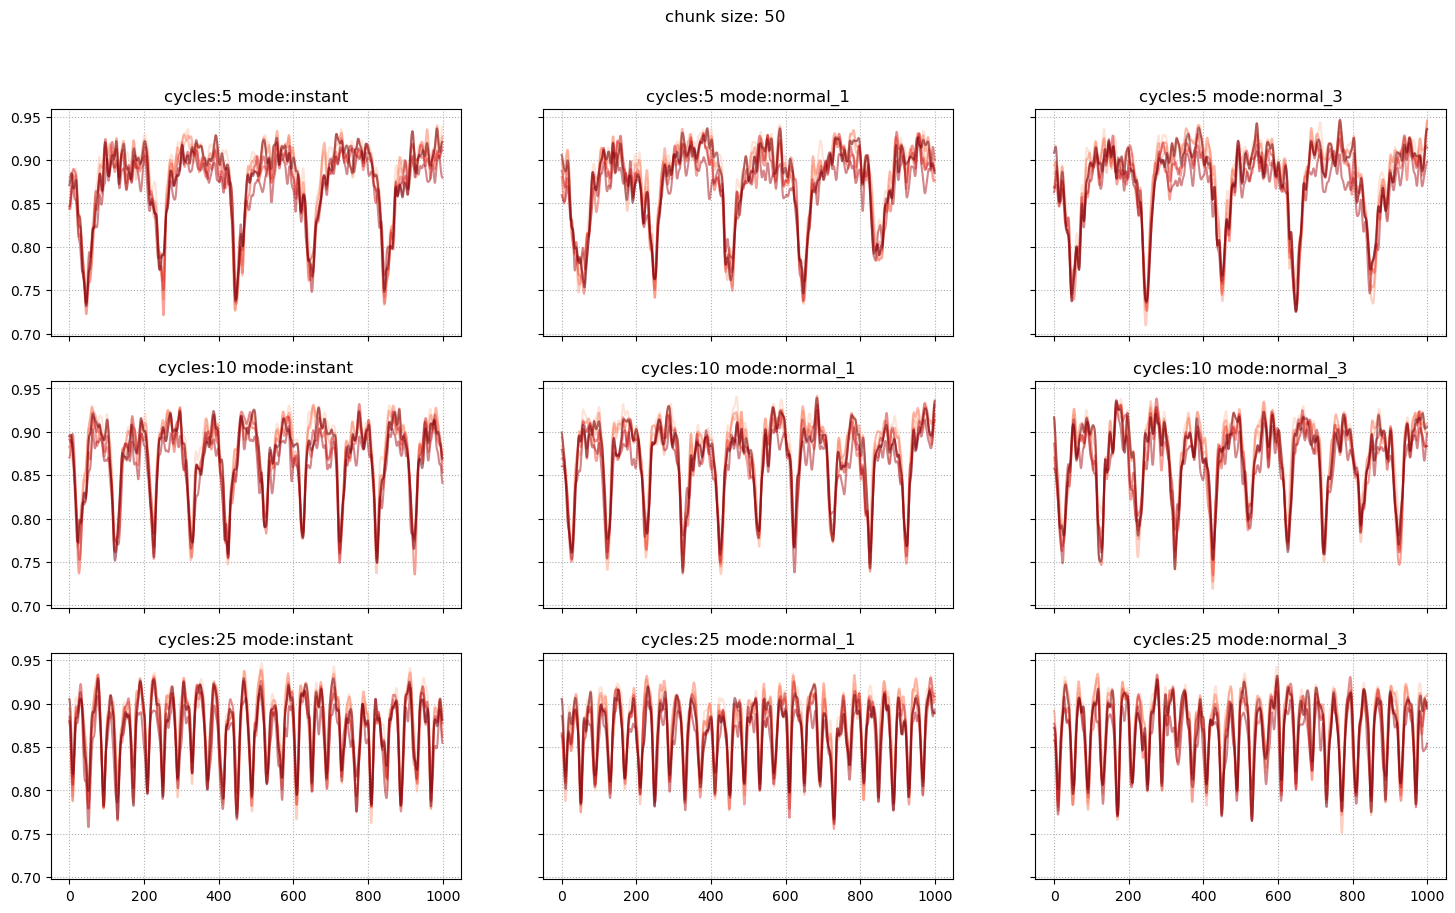

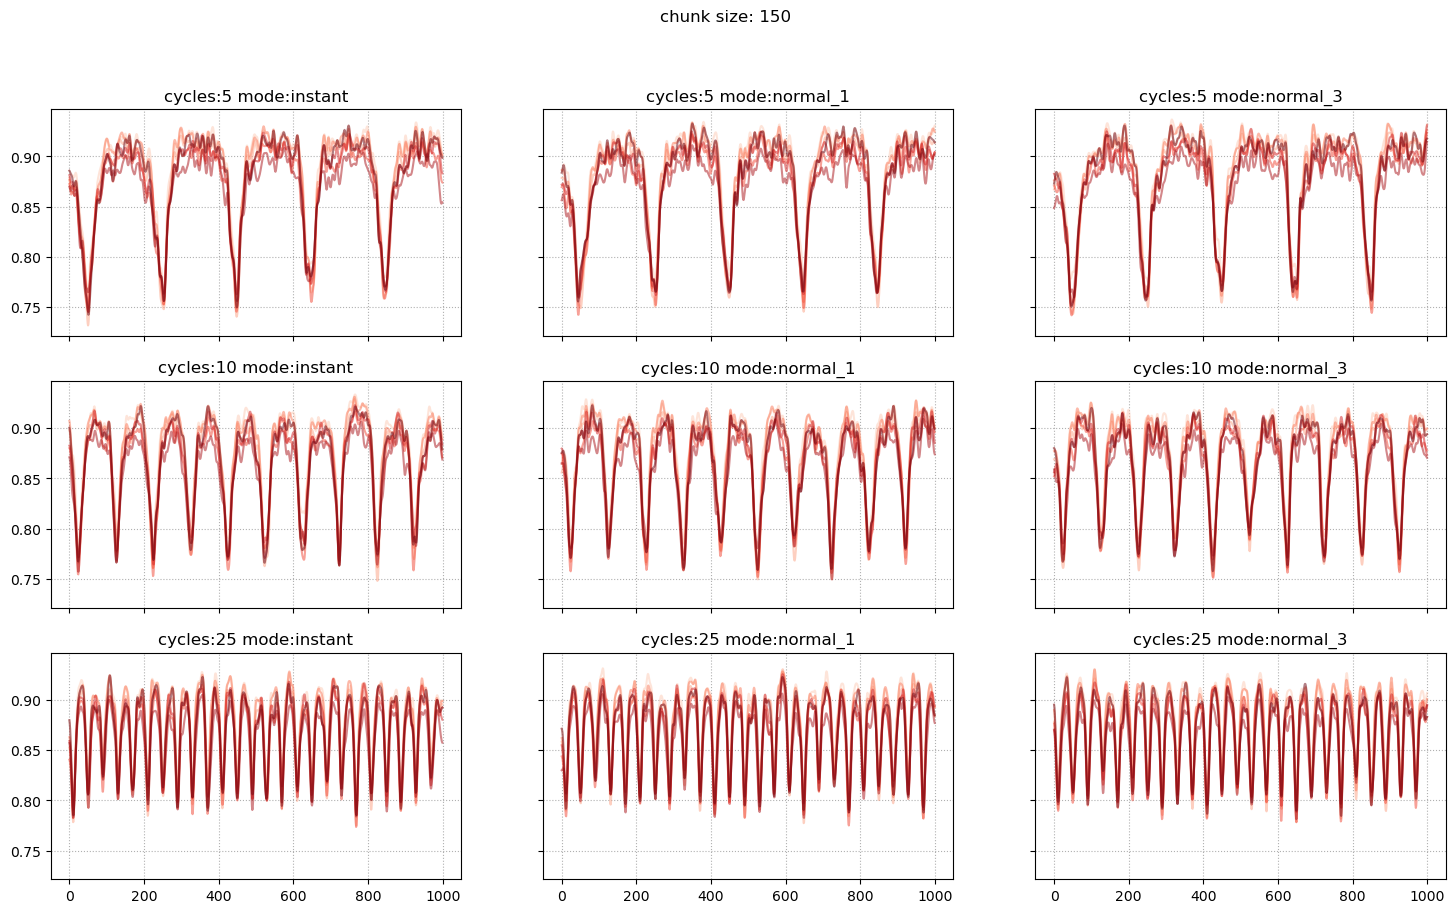

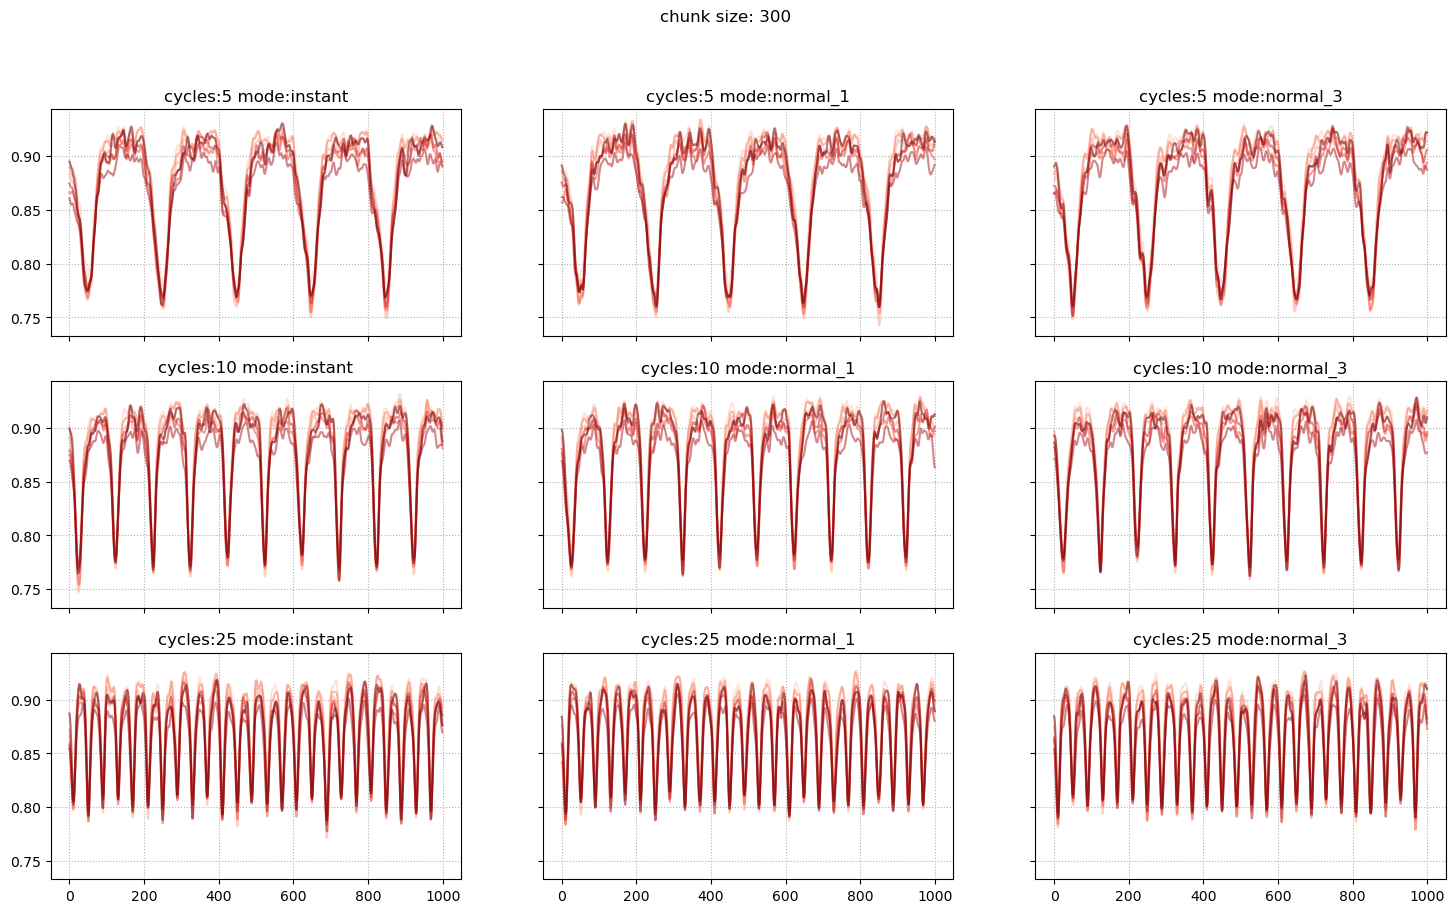

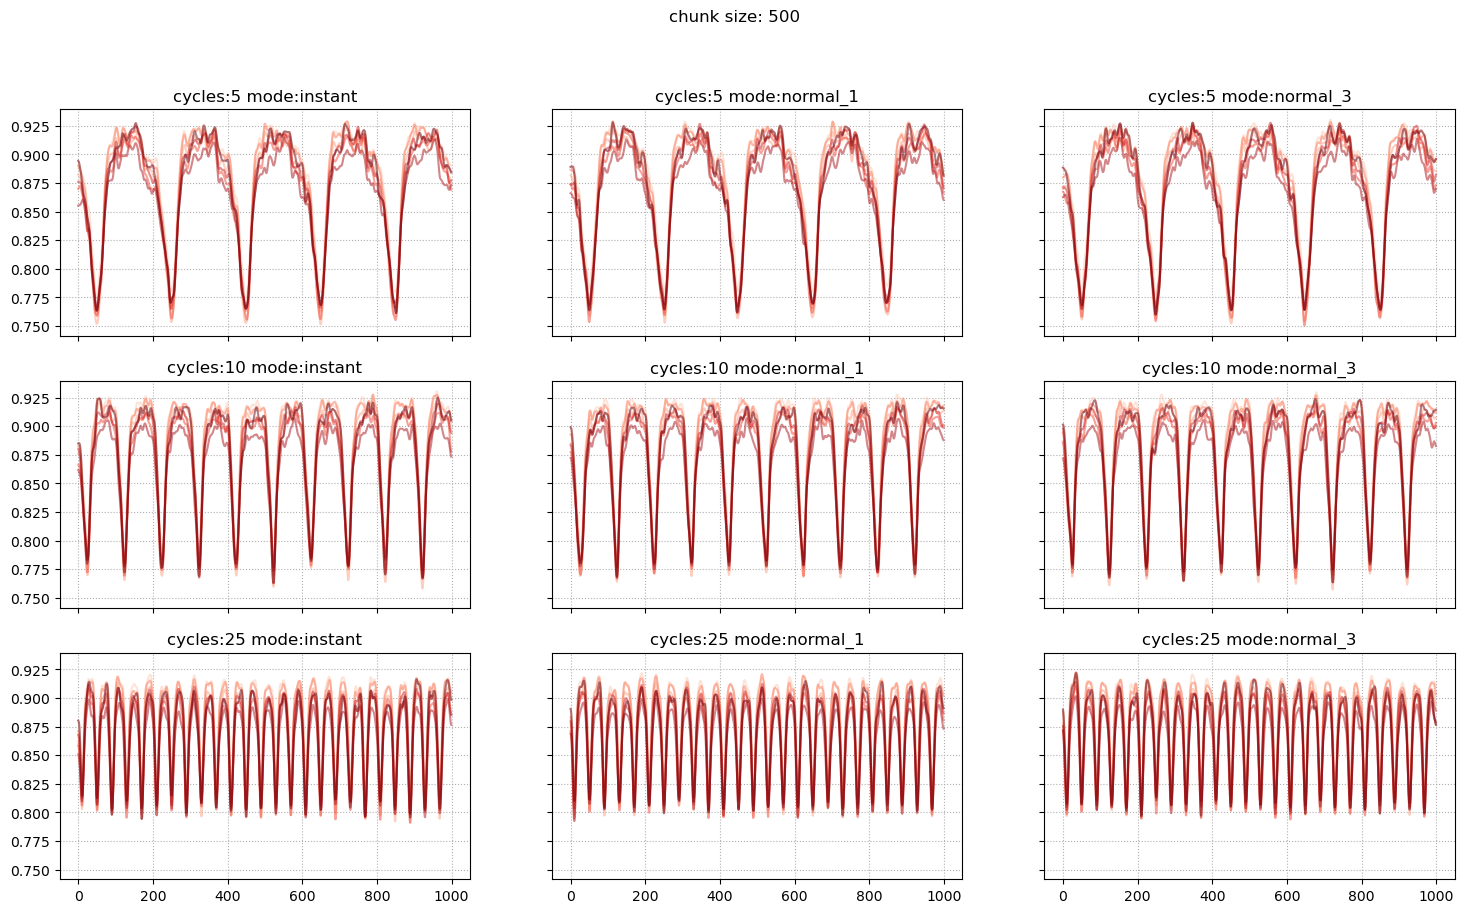

In [68]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

s=3
cols = plt.cm.Reds(np.linspace(0.2,1,7))

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    plt.suptitle('chunk size: %i' % c)

    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            for method_id in range(7):
                temp = accs[c_id, n_c_id, mode_id, :, method_id]
                ax[n_c_id, mode_id].plot(gaussian_filter1d(temp, s), c=cols[method_id], alpha=0.5)
            
            ax[n_c_id, mode_id].set_title('cycles:%i mode:%s' % (n_c, mode))
            ax[n_c_id, mode_id].grid(ls=':')

    
    plt.show()
    
                

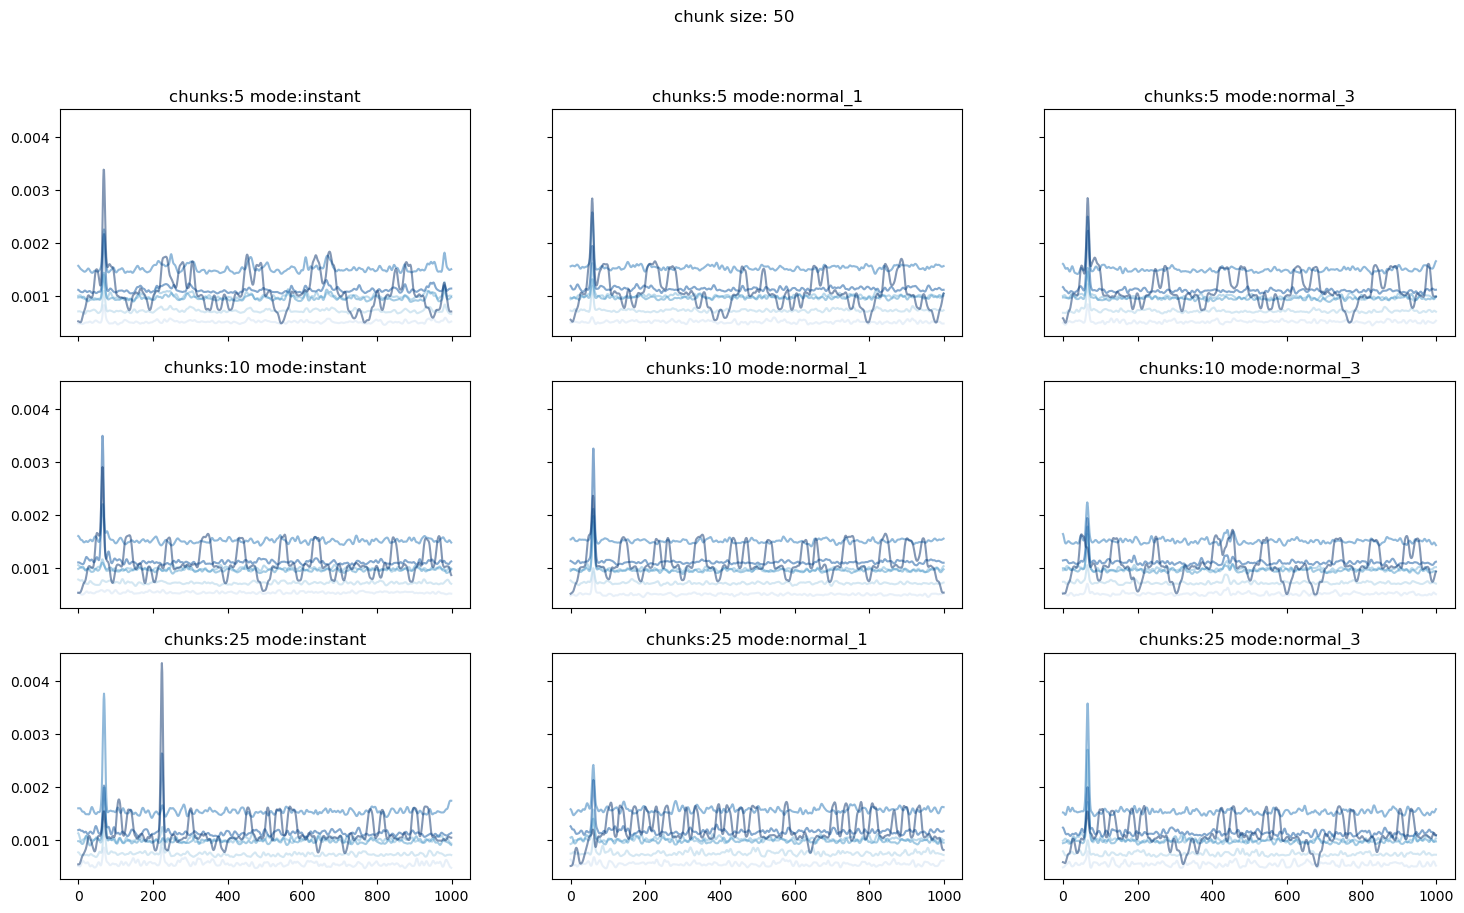

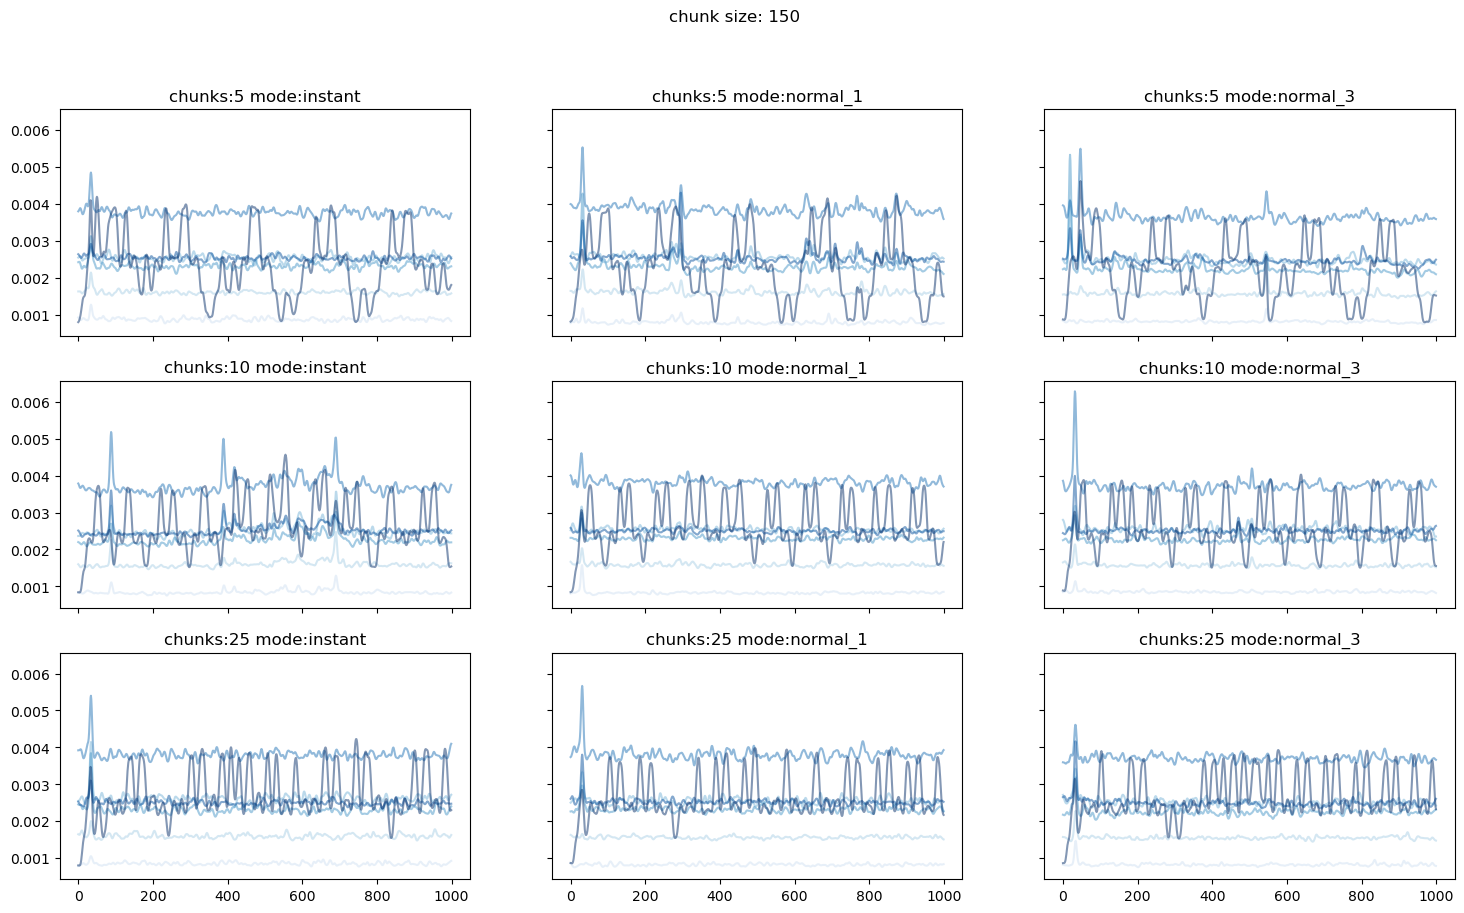

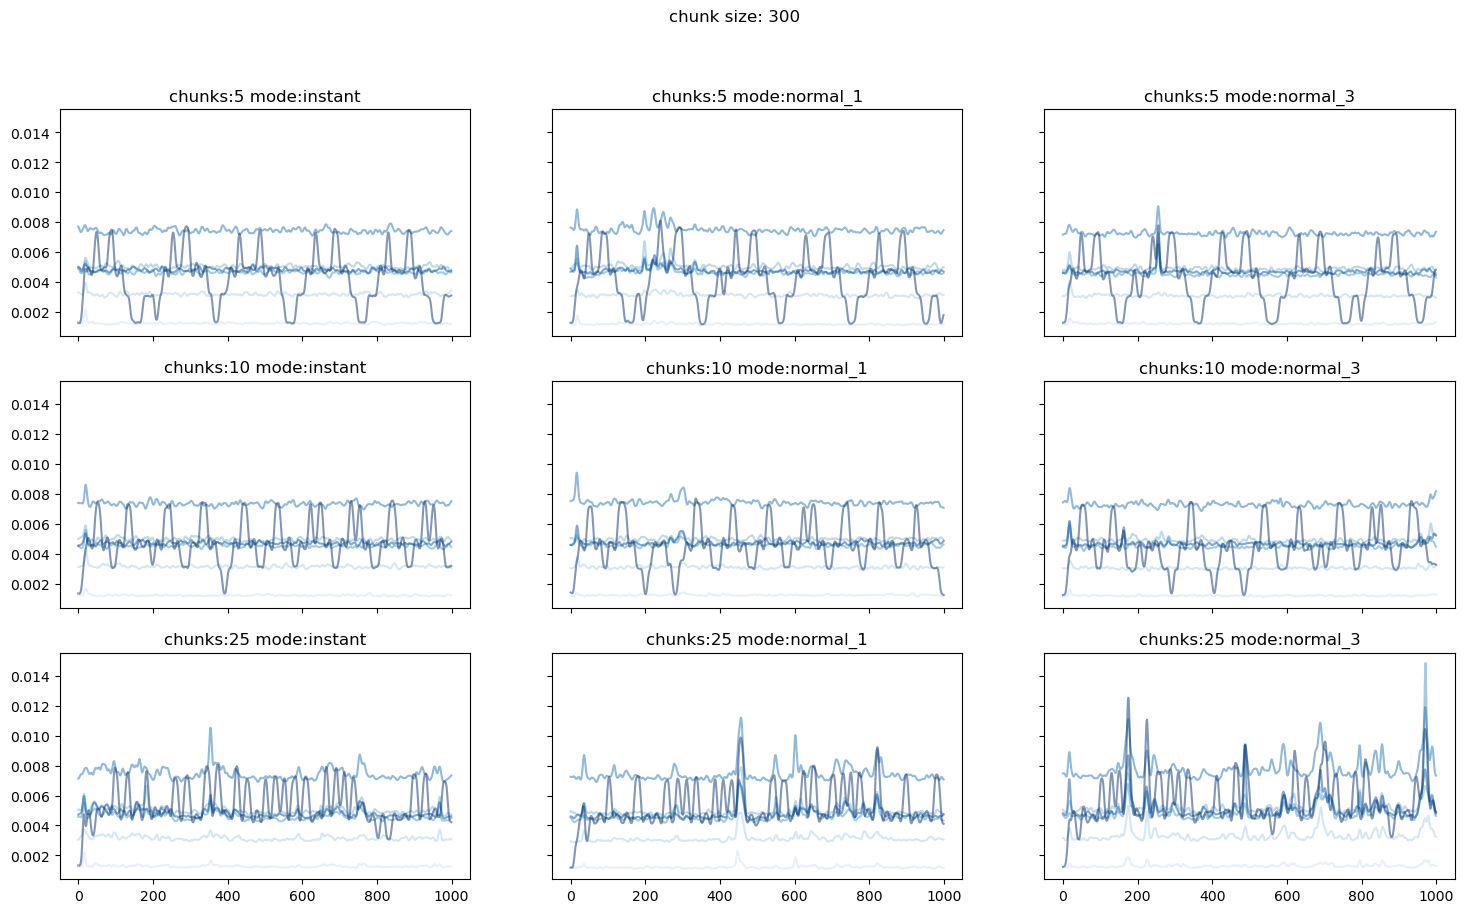

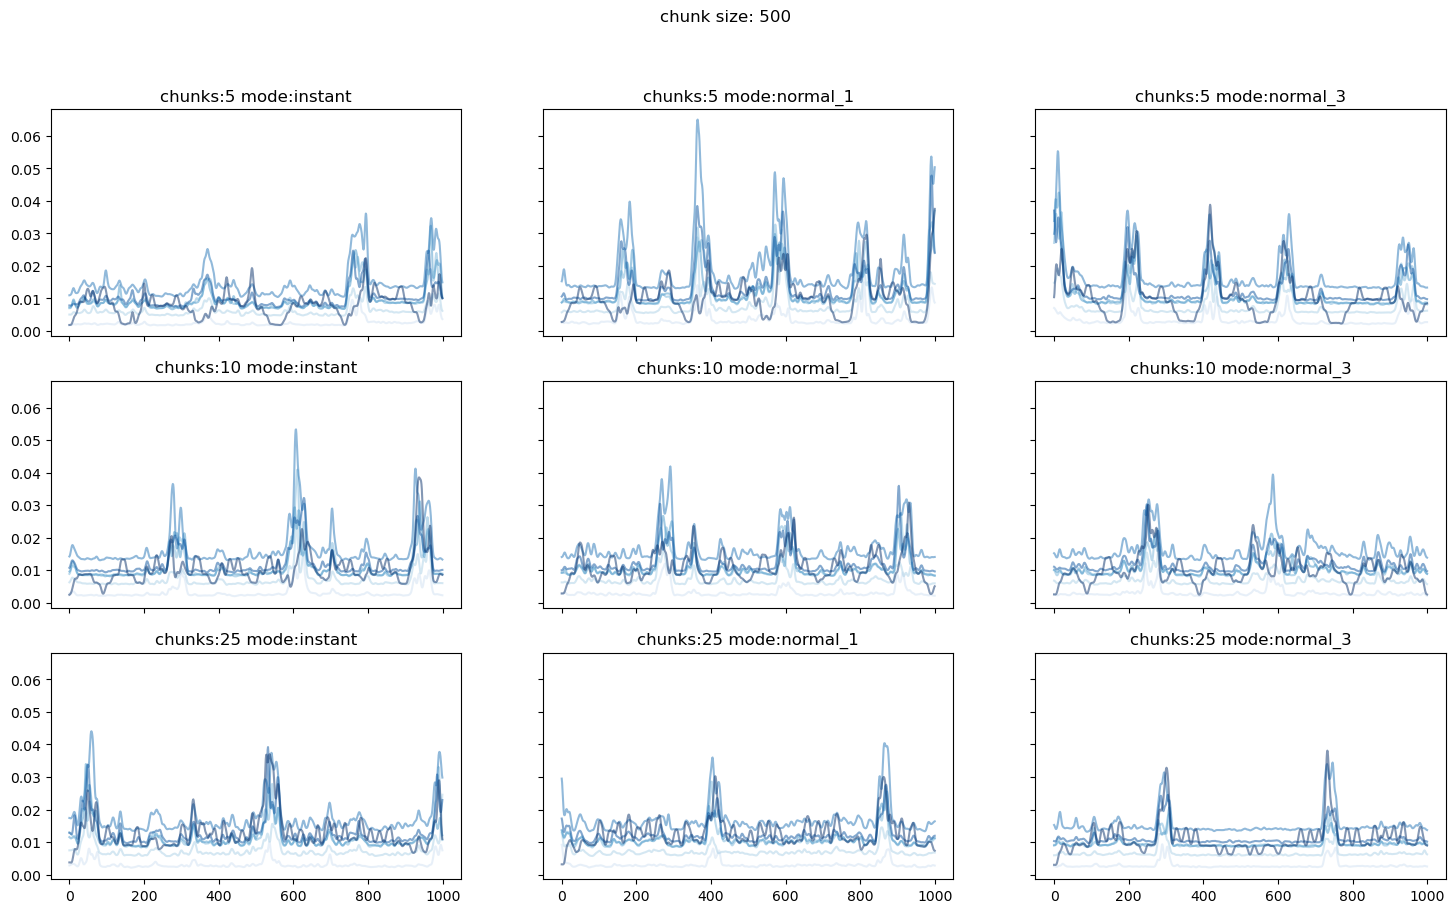

In [69]:
cols = plt.cm.Blues(np.linspace(0.2,1,7))

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    plt.suptitle('chunk size: %i' % c)

    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('chunks:%i mode:%s' % (n_c, mode))
            for method_id in range(7):
                temp = times[c_id, n_c_id, mode_id, :, method_id]
                ax[n_c_id, mode_id].plot(gaussian_filter1d(temp, s), c=cols[method_id], alpha=0.5)
    
    plt.show()

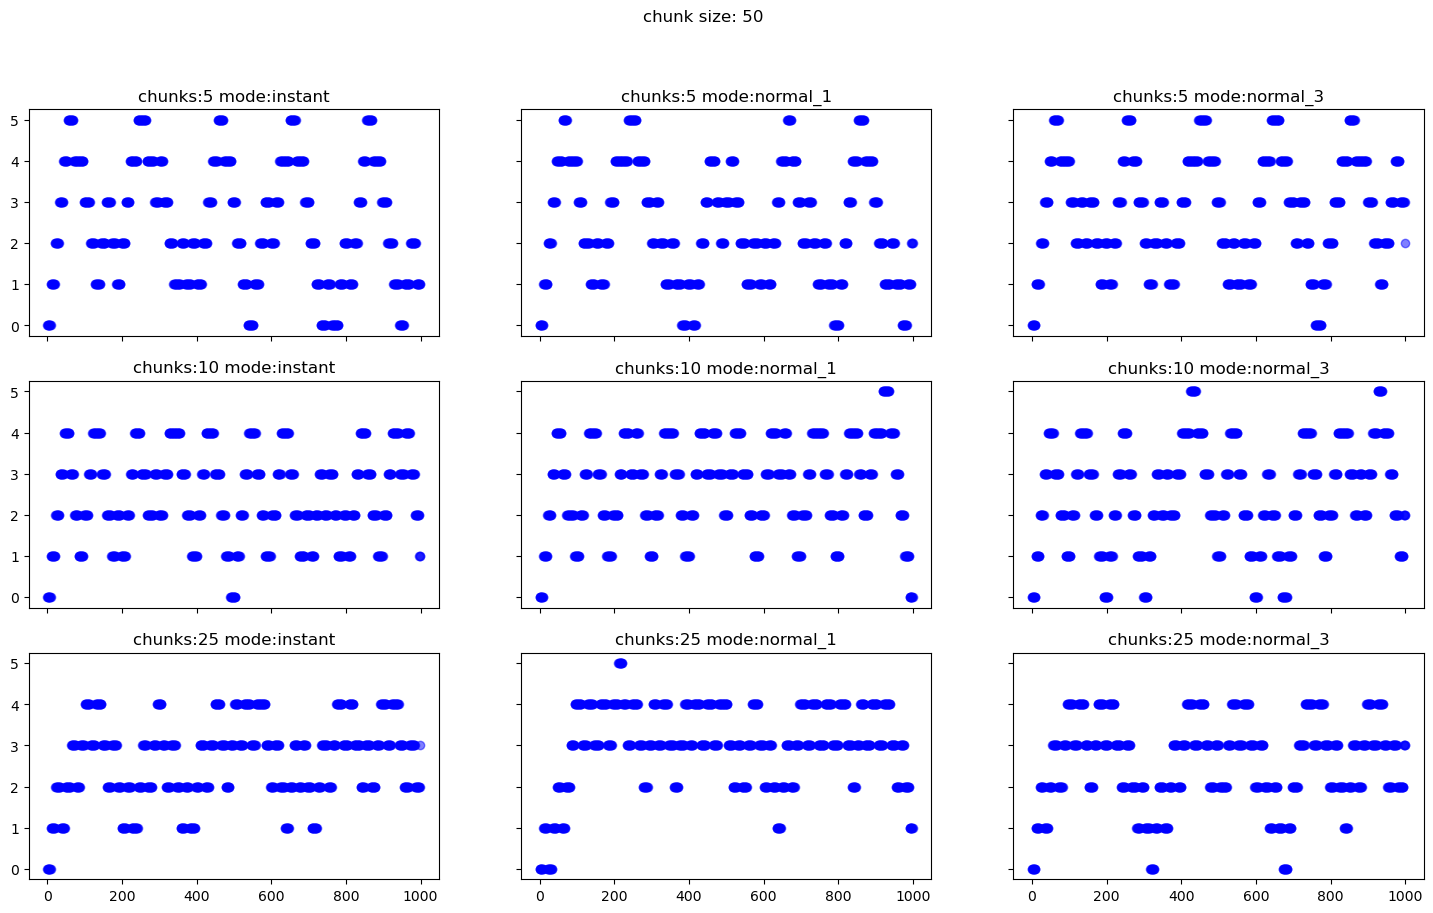

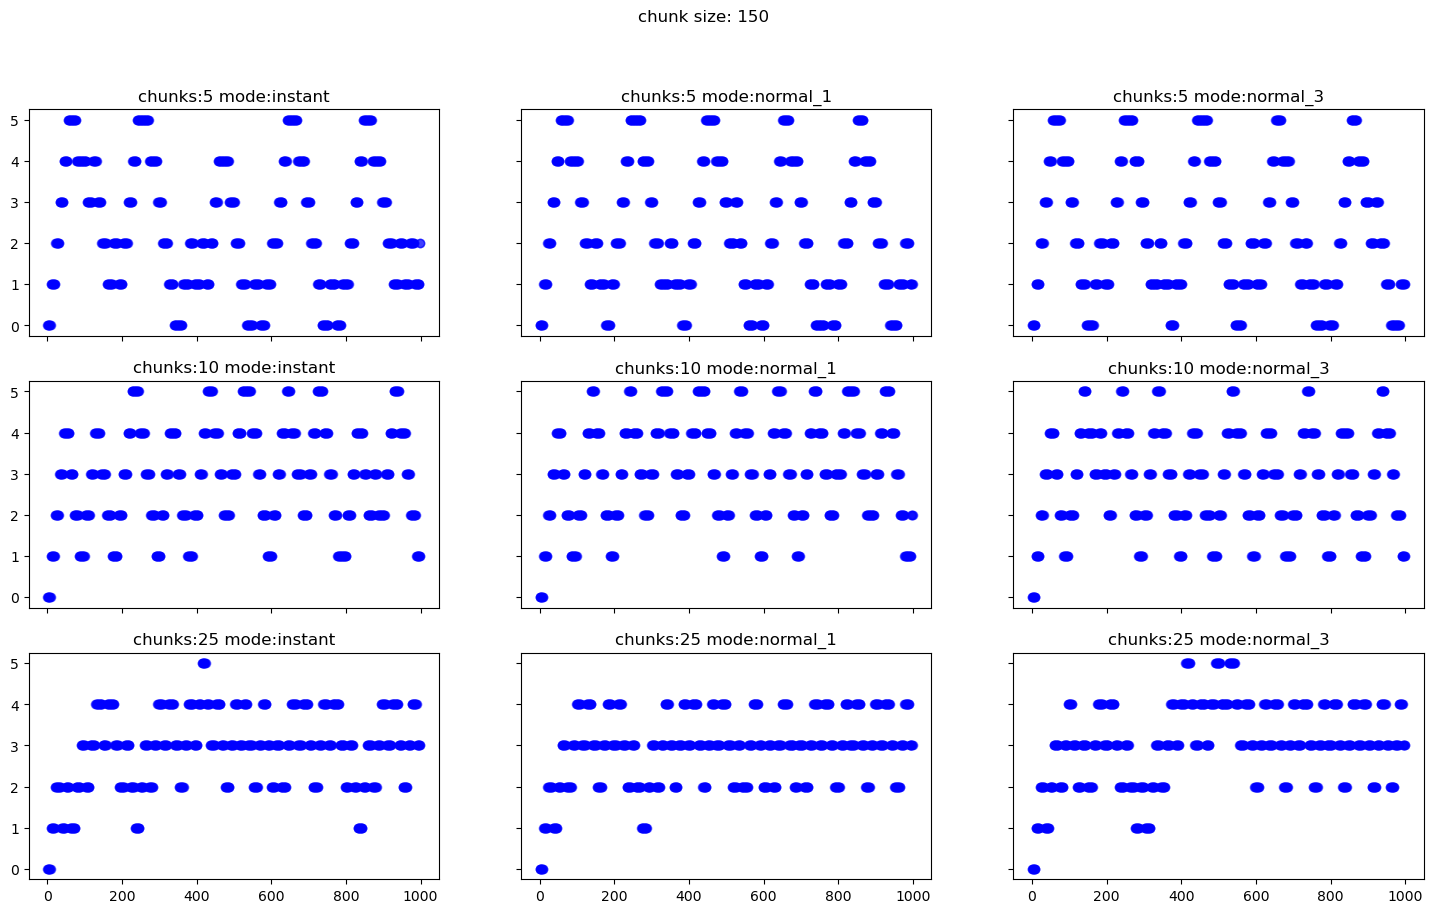

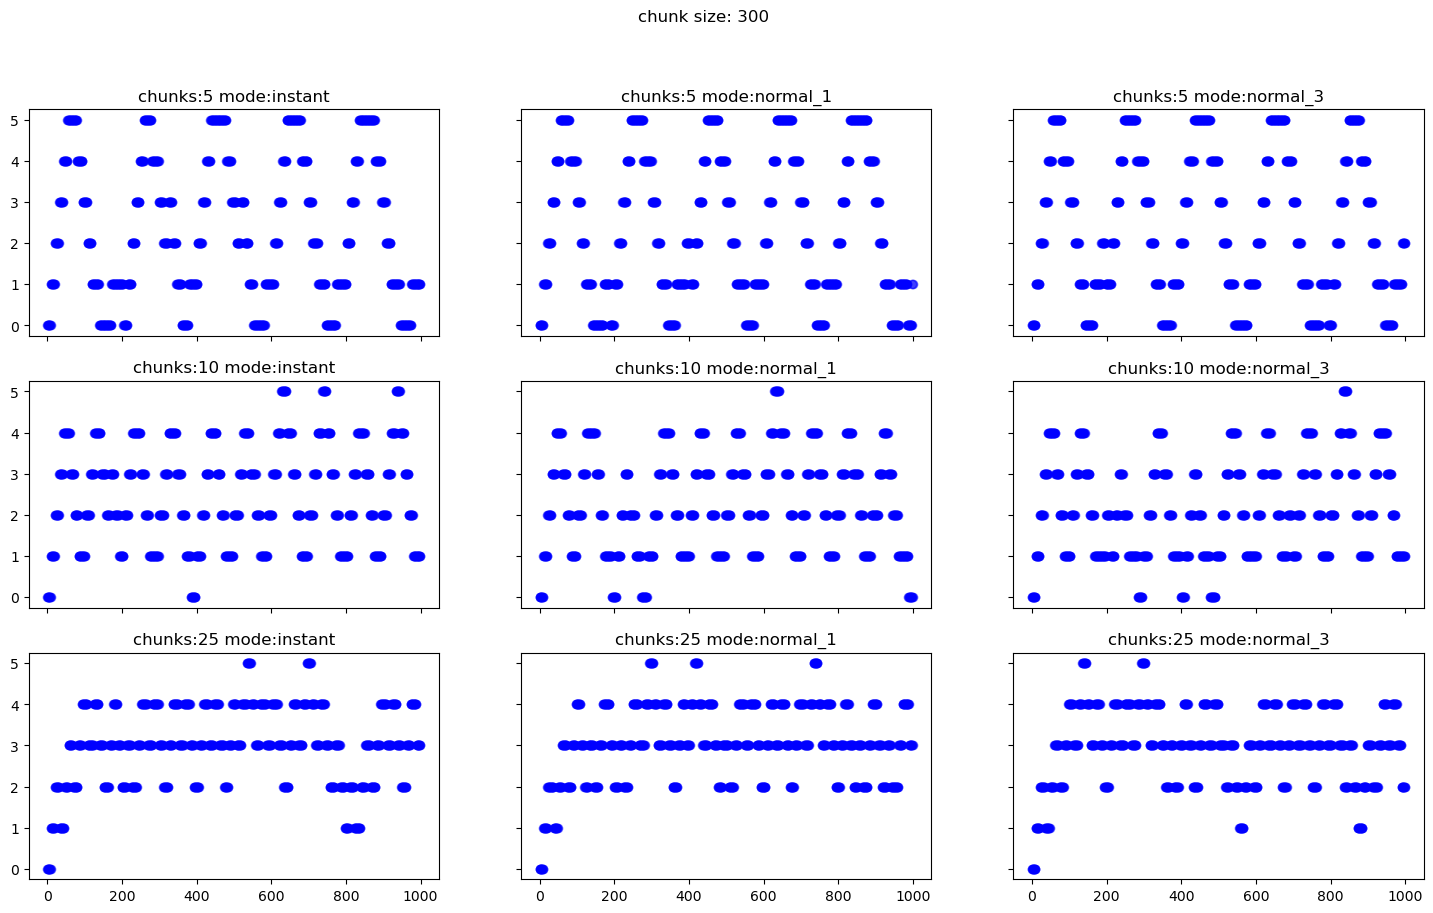

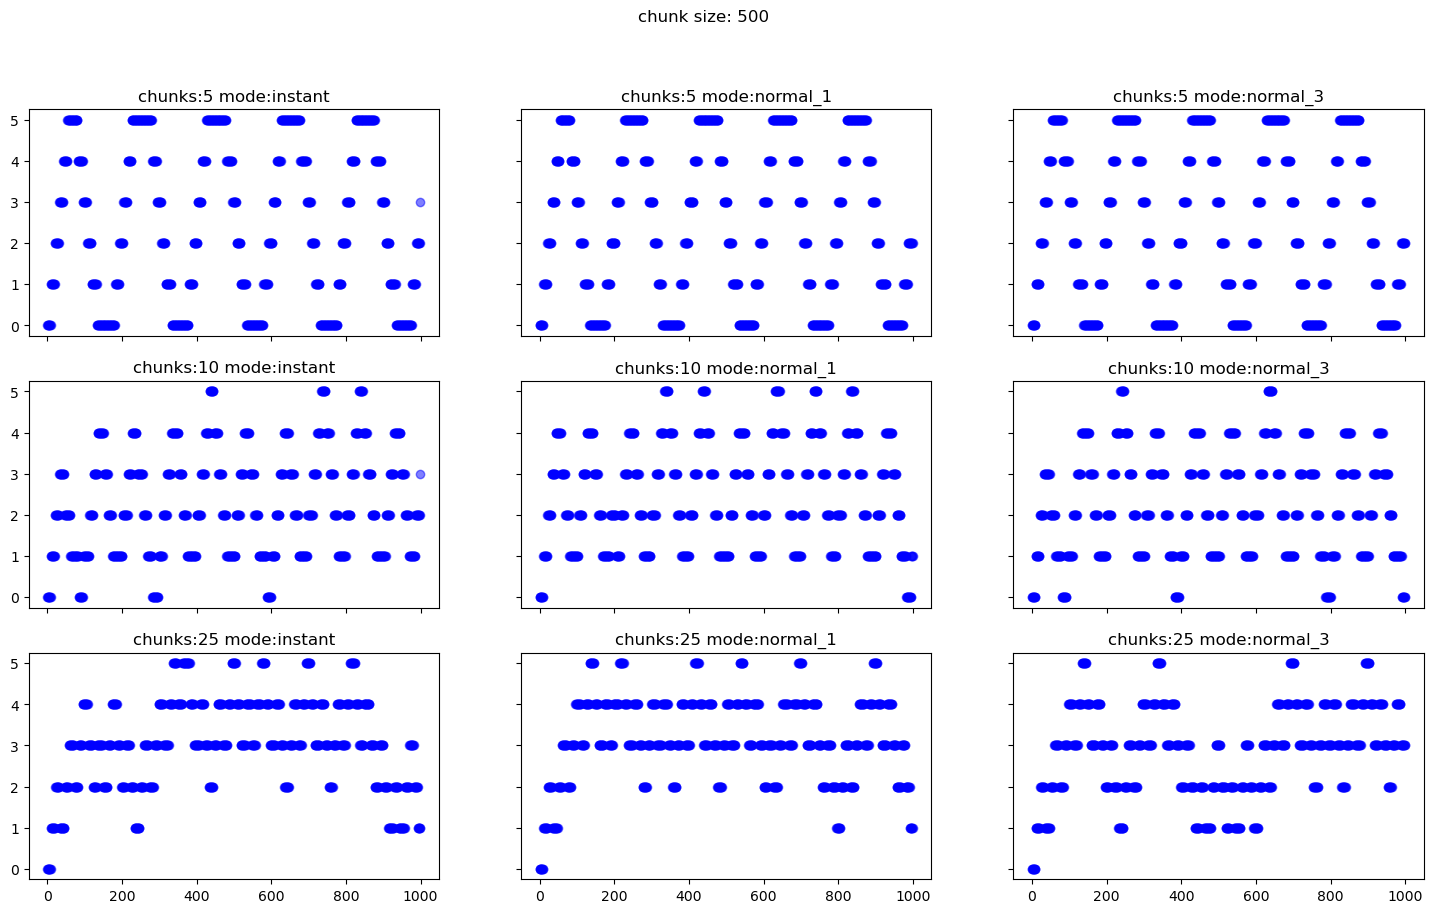

In [70]:
sel = np.load('results/e1_selected_m.npy')

for c_id, c in enumerate(chunk_size):
    fig, ax = plt.subplots(3,3, figsize=(18,10), sharex=True, sharey=True)
    plt.suptitle('chunk size: %i' % c)
    
    for n_c_id, n_c in enumerate(n_cycles):
        for mode_id, mode in enumerate(modes):
            
            ax[n_c_id, mode_id].set_title('chunks:%i mode:%s' % (n_c, mode))
            
            temp = sel[c_id, n_c_id, mode_id]
            ax[n_c_id, mode_id].scatter(np.arange(n_chunks), temp, c='blue', alpha=0.5)

    plt.show()